https://stephenholiday.com/articles/2011/gender-prediction-with-python/

In [162]:
import pandas as pd
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from time import time, ctime
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

import wordninja

In [163]:
df = pd.read_csv('./users.gender.golden.csv')
print df.shape
print df['fname.gender'].value_counts(dropna=False)
df.head()

(121335, 9)
NaN       71935
male      40389
female     9011
Name: fname.gender, dtype: int64


,user_id,username,freq,male.prob,fname.gender,male.prob2,fname.gender2,Name,pic.gender
0,5.0,billion,2.0,1.0000,male,0.920000,male,NaN,NaN
1,63.0,paddyshyam,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64.0,ArmenSoft,1.0,1.0000,male,NaN,NaN,NaN,NaN
3,128.0,okbookman,1.0,0.9945,male,0.998834,male,NaN,NaN
4,215.0,revitupmedia,1.0,1.0000,male,NaN,NaN,215_profile.jpg,NaN


In [164]:
pre9=df[(~df['fname.gender'].isnull())][['username','fname.gender']]
print pre9.shape

pre1=df[(~df['fname.gender'].isnull())& abs(df['male.prob']-0.5)>0.4][['username','fname.gender']]
pre1.shape
pre1.head()

(49400, 2)


,username,fname.gender
0,billion,male
2,ArmenSoft,male
3,okbookman,male
4,revitupmedia,male
7,sakshiinfosys,male


In [165]:
pre1['split_words']=pre1['username'].\
apply(lambda x: ''.join([i for i in str(x) if i.isdigit()==False])).\
apply(lambda x: wordninja.split(str(x).lower()))

from genderizer.genderizer import Genderizer
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)

def helper(X):
    tmp = list(map(d.get_gender, X))
    tmp = [i for i in tmp if i!='unknown']
    try:
        tmp[0]
        if len(tmp)>1:
            m=0
            f=0
            for i in tmp:
                if i in ['male','mostly_male','andy']:
                    m+=1
                elif i in ['female','mostly_female']:
                    f+=1
            if m>=f:
                return 'male'
            else:
                return 'female'
        else:
            if tmp[0] in ['male','mostly_male','andy']:
                    return 'male'
            else:
                return 'female'
    except:
        return 'unknow'
    
pre1['username_split_predict'] = pre1['split_words'].apply(helper)
pre1 = pre1.drop(['split_words'],axis=1)
pre1.tail()

,username,fname.gender,username_split_predict
121328,gewens,male,male
121329,Alexa77,female,female
121330,ilmanen,female,male
121332,xmonika,female,female
121333,lidsoft,male,unknow


In [166]:
def name_count(name):
    arr = np.zeros(52+26*26+3)
    # Iterate each character
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
        arr[ord(x)-ord('a')+26] += ind+1
    # Iterate every 2 characters
    for x in xrange(len(name)-1):
        ind = (ord(name[x])-ord('a'))*26 + (ord(name[x+1])-ord('a')) + 52
        arr[ind] += 1
        # Last character
        arr[-3] = ord(name[-1])-ord('a')
        # Second Last character
        arr[-2] = ord(name[-2])-ord('a')
    # Length of name
    arr[-1] = len(name)
    return arr

In [167]:
52+26*26+3

731

In [168]:
%%time
pre1 =pre1.reset_index(drop=True)

pre1['mock_name']= pre1['username'].apply(lambda x: ''.join([i.lower() for i in str(x) if i.isdigit()==False]))
list_list =np.array(map(name_count, pre1['mock_name']))
print list_list.shape
tmp = pd.DataFrame(data=list_list, columns=['feature_'+str(i) for i in range(731)])
print tmp.shape
tmp.head(1)

(49260, 731)
(49260, 731)
CPU times: user 958 ms, sys: 56 ms, total: 1.01 s
Wall time: 1.01 s


In [169]:
# %%time
# print cross_val_score(RandomForestClassifier(), tmp, pre0['fname.gender'], cv=10)

In [170]:
# name_count('abcdfaa')

In [171]:
# tmp = pd.DataFrame(data=name_count('abcdfaa').reshape(1,-1), columns=['feature_'+str(i) for i in range(731)])
# tmp

In [172]:
pre1.shape

(49260, 4)

In [173]:
pre1.head()

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,male,okbookman
3,revitupmedia,male,unknow,revitupmedia
4,sakshiinfosys,male,male,sakshiinfosys


In [174]:
# pre0.head()

In [175]:
%%time
def add_features(df):
    
    df['last']= df['username'].str[-1]
    df['last_two']= df['username'].str[-2:]
    df['last_three']= df['username'].str[-3:]
    df['first']= df['username'].str[0].str.lower()
    df['first2']= df['username'].str[:2]
    df['first3']= df['username'].str[:3]
    df['nchar']= df['username'].apply(lambda x: len(str(x)))
    df['vowels.pct']=df['username'].apply(lambda x: len([i for i in str(x) if i in 'aeiouy'])/float(len(str(x))))
    df['digits.pct']=df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)])/float(len(str(x))))
    df['last_is_vowel'] = df['username'].apply(lambda x: str(x)[-1] in 'aeiouy')
    df['first_is_vowel'] = df['username'].apply(lambda x: str(x)[0] in 'aeiouy')
    df['last_is_digit'] = df['username'].apply(lambda x: str(x)[-1].isdigit())
    df['first_is_digit'] = df['username'].apply(lambda x: str(x)[0].isdigit())
    df['digits.num'] = df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)]))
    df['upper.pct'] = df['username'].apply(lambda x: sum([i.isupper() for i in str(x)]))
    df['first_is_upper'] = df['username'].apply(lambda x: str(x)[0].isupper())
    df.pop('mock_name')
    
    
    

    
pre0=pre1.copy()

add_features(pre0)

pre0 = pd.concat([pre0, tmp], axis=1)

print pre0.shape

(49260, 750)
CPU times: user 573 ms, sys: 54 ms, total: 627 ms
Wall time: 625 ms


In [176]:
pre0.head(1)

,username,fname.gender,username_split_predict,last,last_two,last_three,first,first2,first3,nchar,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,ion,b,bi,bil,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0


In [177]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,last_three,first,first2,first3,nchar,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,ion,b,bi,bil,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,oft,a,Ar,Arm,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,male,n,an,man,o,ok,okb,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,dia,r,re,rev,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,sys,s,sa,sak,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [178]:
# pre0.to_csv('./preprocessed.csv', index=False)

In [179]:
print pre0.iloc[:,1].value_counts()
40389.0/(40389+8871)

male      40389
female     8871
Name: fname.gender, dtype: int64


0.8199147381242388

### accuracy if set all male

In [180]:
# print pre0.columns.values
print pre0.columns.values[2:9]
pre0.head()

['username_split_predict' 'last' 'last_two' 'last_three' 'first' 'first2'
 'first3']


,username,fname.gender,username_split_predict,last,last_two,last_three,first,first2,first3,nchar,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,ion,b,bi,bil,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,oft,a,Ar,Arm,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,male,n,an,man,o,ok,okb,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,dia,r,re,rev,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,sys,s,sa,sak,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [181]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,last_three,first,first2,first3,nchar,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,ion,b,bi,bil,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,oft,a,Ar,Arm,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,male,n,an,man,o,ok,okb,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,dia,r,re,rev,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,sys,s,sa,sak,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [187]:
%%time
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(df[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed
 
to_be_encoded_cols = pre0.columns.values[2:9]
label_encode(pre0, to_be_encoded_cols)


CPU times: user 112 ms, sys: 999 µs, total: 113 ms
Wall time: 112 ms


In [188]:
X_train, X_test, y_train, y_test =train_test_split(pre0.iloc[:,2:], pre0.iloc[:,1], test_size=.3, stratify =pre0.iloc[:,1])
print dim(X_train, y_train, X_test, y_test )
X_train.head(1)

[(34482, 748), (34482,), (14778, 748), (14778,)]


,username_split_predict,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,digits.pct,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
28080,0,9,244,1181,20,1599,10211,14,0.214286,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,19.0,7.0


In [189]:
# pre0.to_csv('preprocessed.csv',index=False)

In [190]:
# cross_val_score(RandomForestClassifier(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)
print y_train.value_counts()

## true labels
print len(y_test)
y_test.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64
14778


male      12117
female     2661
Name: fname.gender, dtype: int64

In [191]:
%%time
fr=RandomForestClassifier()
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3.47 s, sys: 116 ms, total: 3.58 s
Wall time: 3.58 s


0.819935038571
0.819055352551
Confusion matrix, without normalization
[[  396  2265]
 [  409 11708]]


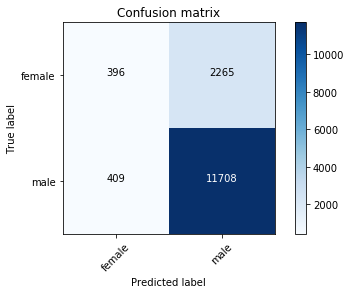

In [192]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [193]:
%%time
fr=RandomForestClassifier(n_estimators=150, min_samples_split=5, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 51.1 s, sys: 288 ms, total: 51.4 s
Wall time: 4.3 s


0.819935038571
0.832182974692
Confusion matrix, without normalization
[[  206  2455]
 [   25 12092]]


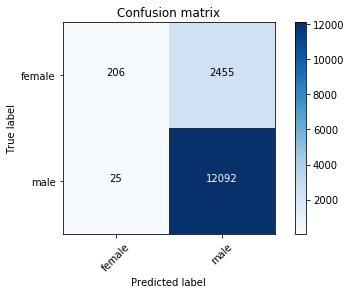

In [194]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [195]:
%%time
fr=RandomForestClassifier(n_estimators=640, min_samples_split=6, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3min 32s, sys: 823 ms, total: 3min 33s
Wall time: 12 s


0.819935038571
0.830558938963
Confusion matrix, without normalization
[[  174  2487]
 [   17 12100]]


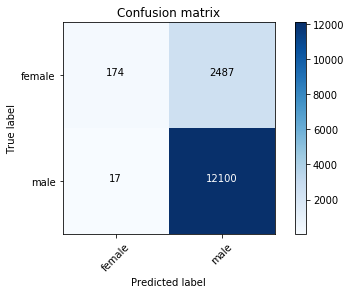

In [196]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [197]:
def plotting(model, df, num):
    forest = model
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]



    # Plot the feature importances of the forest
    plt.figure(figsize=(16,8))
    plt.title("Feature importances")
    plt.barh(range(num), importances[indices][:num],
           color="g", xerr=std[indices][:num], 
            align="center", alpha=.7)

    plt.yticks(range(num), list(df.columns[indices][:num],))
    plt.ylim([-1, num])

    plt.gca().invert_yaxis()

    plt.show()

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(df.shape[1]):
        print("{}. feature {} ({:.2f} %)" .format (f + 1, df.columns[indices[f]], 100*importances[indices[f]]))

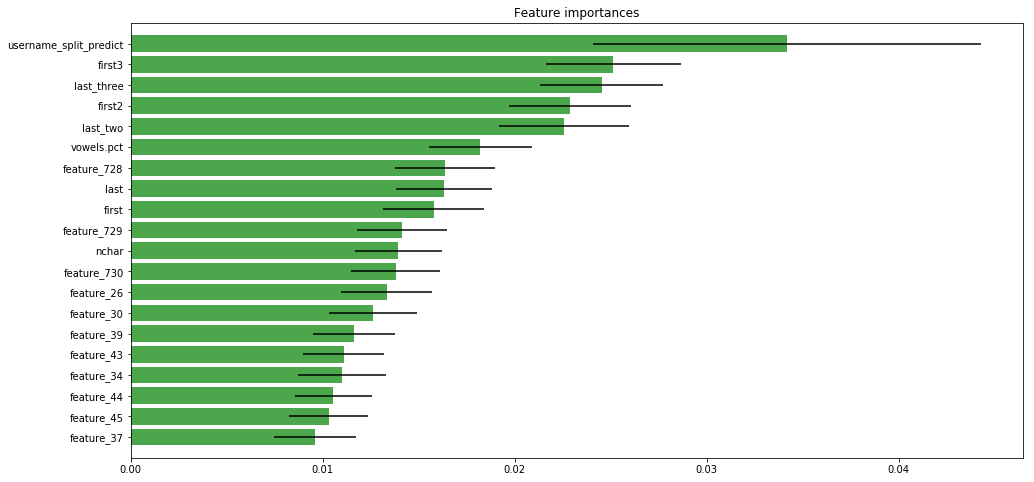

Feature ranking:
1. feature username_split_predict (3.42 %)
2. feature first3 (2.51 %)
3. feature last_three (2.45 %)
4. feature first2 (2.29 %)
5. feature last_two (2.26 %)
6. feature vowels.pct (1.82 %)
7. feature feature_728 (1.64 %)
8. feature last (1.63 %)
9. feature first (1.58 %)
10. feature feature_729 (1.41 %)
11. feature nchar (1.39 %)
12. feature feature_730 (1.38 %)
13. feature feature_26 (1.33 %)
14. feature feature_30 (1.26 %)
15. feature feature_39 (1.16 %)
16. feature feature_43 (1.11 %)
17. feature feature_34 (1.10 %)
18. feature feature_44 (1.06 %)
19. feature feature_45 (1.03 %)
20. feature feature_37 (0.96 %)
21. feature feature_40 (0.95 %)
22. feature digits.pct (0.91 %)
23. feature feature_28 (0.85 %)
24. feature feature_38 (0.82 %)
25. feature feature_33 (0.77 %)
26. feature feature_29 (0.75 %)
27. feature feature_0 (0.69 %)
28. feature feature_27 (0.68 %)
29. feature feature_36 (0.67 %)
30. feature feature_32 (0.67 %)
31. feature feature_46 (0.65 %)
32. feature 

In [198]:
plotting(fr, X_train, 20)

In [112]:
RandomForestClassifier?

In [103]:
%%time
fr=RandomForestClassifier(n_estimators=200
                          , min_samples_split=6, n_jobs=24, criterion='entropy')
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 1min 2s, sys: 341 ms, total: 1min 3s
Wall time: 5.07 s


0.819935038571
0.832047638381
Confusion matrix, without normalization
[[  202  2459]
 [   23 12094]]


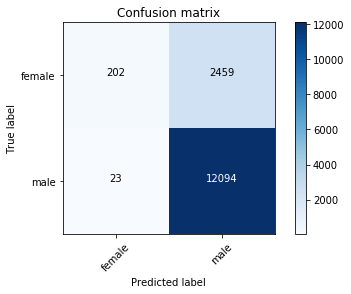

In [104]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [16]:
RandomForestClassifier?

In [152]:
print 12117/14778.0

0.819935038571


In [27]:
%%time
fr=RandomForestClassifier(n_estimators=102400, min_samples_split=6, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 8h 57min 23s, sys: 1min 26s, total: 8h 58min 50s
Wall time: 25min 25s


0.819935038571
0.827581540127
Confusion matrix, without normalization
[[  119  2542]
 [    6 12111]]


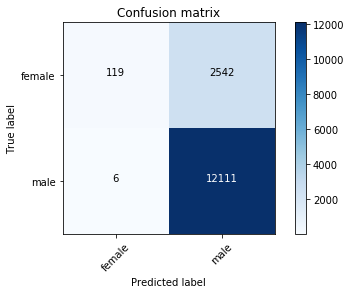

In [28]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [30]:
SVC?

https://stackoverflow.com/questions/9299346/fastest-svm-implementation-usable-in-python

In [ ]:
%%time
svm=SVC()
svm.fit(X_train, y_train)
## predict labels
svm_p = svm.predict(X_test)
pd.Series(svm_p).value_counts()

0.819935038571
0.818040330221
Confusion matrix, without normalization
[[   80  2581]
 [  108 12009]]


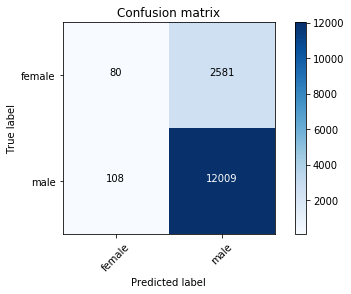

In [34]:
print 12117/14778.0
print accuracy_score(y_test, svm_p)
plot_confusion_matrix(confusion_matrix(y_test,svm_p), ['female','male'])

0.716064420084
Confusion matrix, without normalization
[[  515  2146]
 [ 2050 10067]]


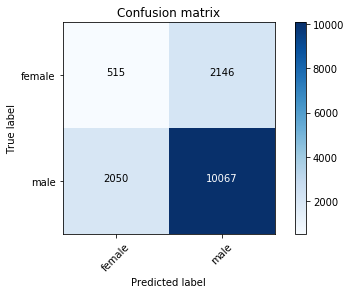

CPU times: user 8.91 s, sys: 2.33 s, total: 11.2 s
Wall time: 8.78 s


In [105]:
%%time
lsvm = LinearSVC()
lsvm.fit(X_train, y_train)
lsvm_pr=lsvm.predict(X_test)
pd.Series(lsvm_pr).value_counts()
print accuracy_score(y_test, lsvm_pr)
plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

In [106]:
confusion_matrix(y_test,fr_p)

array([[  202,  2459],
       [   23, 12094]])

In [108]:
# d_train.get_label()

### try xgboost

https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [109]:
import xgboost as xgb

/home/shj16110/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [110]:
d_train = xgb.DMatrix(X_train, label=y_train.map({'male':1, 'female':0}))
d_test = xgb.DMatrix(X_test, label=y_test.map({'male':1, 'female':0}))

In [111]:
d_train.get_label()

array([ 0.,  1.,  1., ...,  1.,  0.,  1.], dtype=float32)

In [134]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [129]:
def female_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    cof = confusion_matrix(y, tmp)
    g_f_c = cof[0][0]
    b_f_c = cof[1][0]
    r_f_c = cof[0][1]
    target = (g_f_c - 1.1*b_f_c)/float(r_f_c)
    return 'female_acc',target
    

In [130]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, 
                verbose_eval=20, feval=female_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-female_acc:0.325461	test-female_acc:-0.351785
Multiple eval metrics have been passed: 'test-female_acc' will be used for early stopping.

Will train until test-female_acc hasn't improved in 100 rounds.
[20]	train-female_acc:0.797045	test-female_acc:0.057261
[40]	train-female_acc:1.87265	test-female_acc:0.074643
[60]	train-female_acc:5.06445	test-female_acc:0.086908
[80]	train-female_acc:16.8448	test-female_acc:0.091527
[100]	train-female_acc:81.8	test-female_acc:0.097181
[120]	train-female_acc:364.294	test-female_acc:0.099087
[140]	train-female_acc:775.25	test-female_acc:0.094787
[160]	train-female_acc:1551.5	test-female_acc:0.097649
[180]	train-female_acc:inf	test-female_acc:0.097639


/home/shj16110/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


[200]	train-female_acc:inf	test-female_acc:0.098596
[220]	train-female_acc:inf	test-female_acc:0.098114
[240]	train-female_acc:inf	test-female_acc:0.098595
[260]	train-female_acc:inf	test-female_acc:0.09859
[280]	train-female_acc:inf	test-female_acc:0.095685
[300]	train-female_acc:inf	test-female_acc:0.096651
[320]	train-female_acc:inf	test-female_acc:0.095194
Stopping. Best iteration:
[236]	train-female_acc:inf	test-female_acc:0.102464



'!!! used 140.00 s'

accuracy 0.835363377994
statistic
male      14222
female      556
dtype: int64
Confusion matrix, without normalization
[[  392  2269]
 [  164 11953]]


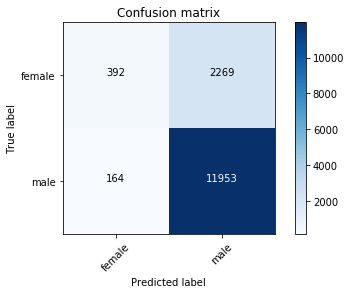

In [131]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

#### on accuracy 

### tune

In [ ]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [175]:
y_train.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64

In [186]:
6210.0/28272

0.21965195246179967

In [236]:
RANDOM_STATE = 2017

params = {
    'min_child_weight': 0.8,
#     'eta': 0.1,
    'colsample_bytree': 0.8,
    'max_depth': 28,
    'subsample': 0.8,
    'alpha': 2,
    'lambda':3,
    'gamma': 0.1,
    'silent': 0,
    'learning_rate':0.01,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12,
        'max_delta_step ':7,
        'colsample_bylevel ':0.9 ,    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [237]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=500, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.837132	test-acc:0.820679
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 500 rounds.
[20]	train-acc:0.842701	test-acc:0.827988
[40]	train-acc:0.842527	test-acc:0.82792
[60]	train-acc:0.844963	test-acc:0.828935
[80]	train-acc:0.845717	test-acc:0.828597
[100]	train-acc:0.847109	test-acc:0.82995
[120]	train-acc:0.848211	test-acc:0.829679
[140]	train-acc:0.849197	test-acc:0.829476
[160]	train-acc:0.850299	test-acc:0.82995
[180]	train-acc:0.85143	test-acc:0.830221
[200]	train-acc:0.852474	test-acc:0.830627
[220]	train-acc:0.853924	test-acc:0.830694
[240]	train-acc:0.854939	test-acc:0.83083
[260]	train-acc:0.856099	test-acc:0.830559
[280]	train-acc:0.85781	test-acc:0.830424
[300]	train-acc:0.859608	test-acc:0.830424
[320]	train-acc:0.861406	test-acc:0.83083
[340]	train-acc:0.864335	test-acc:0.830559
[360]	train-acc:0.8668	test-acc:0.830762
[380]	train-acc:0.869874	test-acc:0.83083
[400]	train-ac

'!!! used 465.33 s'

accuracy 0.836175395859
statistic
male      14190
female      588
dtype: int64
Confusion matrix, without normalization
[[  414  2247]
 [  174 11943]]


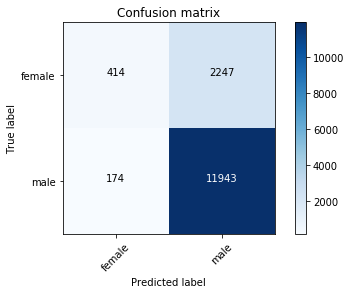

In [239]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

In [248]:
f_ip = pd.DataFrame(clf.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
f_ip.head(10)

,feature,importance
480,last_three,75696
136,last_two,59834
276,first3,59419
357,vowels.pct,48883
415,last,37114
251,first,32742
508,feature_728,27695
418,nchar,27236
507,feature_729,26850
519,feature_30,26037


In [257]:
pd.DataFrame.plot?

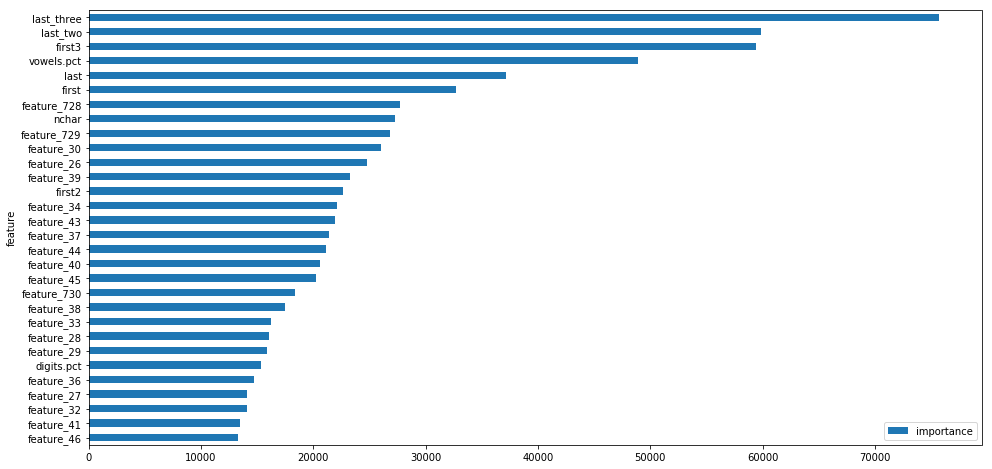

In [273]:
f_ip.head(30).iloc[::-1].set_index('feature').plot(kind='barh', figsize=(16,8))
plt.show()

In [120]:
pre0 = pre1.copy()
pre0.head(3)

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,male,okbookman


### other sklearn models

In [270]:
# %%time
# lsvm = LinearSVC()
# lsvm.fit(X_train, y_train)
# lsvm_pr=lsvm.predict(X_test)
# pd.Series(lsvm_pr).value_counts()
# print accuracy_score(y_test, lsvm_pr)
# plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

In [110]:
# cross_val_score(SVC(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)

In [140]:
# svm = SVC()
# svm

In [141]:
# %%time
# # svm.fit(X_train, y_train)

In [142]:
# from sklearn.neural_network import MLPClassifier

In [143]:
# neur = MLPClassifier(verbose=True, learning_rate='adaptive', hidden_layer_sizes=(200,20,1))
# neur

https://wiki.hpc.uconn.edu/index.php/GPU_Guide

In [145]:
# %%time
# neur.fit(X_train, y_train)
# neur_prd = neur.predict(X_test)

In [146]:
# pd.Series(neur_prd).value_counts()

In [147]:
# accuracy_score(y_test,neur_prd)

In [148]:
# plot_confusion_matrix(confusion_matrix(y_test,neur_prd), ['female','male'])

In [156]:
# %%time
# pred = svm.predict(X_test)
# pred.shape

In [157]:
# pd.Series(pred).value_counts()

In [158]:
# accuracy_score(y_test, pred)

In [159]:
# confusion_matrix(y_test,pred)

In [161]:
# plot_confusion_matrix(confusion_matrix(y_test,pred), ['female','male'])


In [149]:
# from sklearn.naive_bayes import BernoulliNB

In [150]:
# nb = BernoulliNB()
# nb

In [162]:
# %%time
# nb.fit(X_train, y_train)
# nb_pd=nb.predict(X_test)
# print pd.Series(nb_pd).value_counts()